In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

from swiper.lattice_surgery_schedule import LatticeSurgerySchedule
from swiper.schedule_experiments import MemorySchedule, RegularTSchedule, MSD15To1Schedule, RandomTSchedule
from swiper.device_manager import DeviceManager
from swiper.window_builder import WindowBuilder
from swiper.window_manager import SlidingWindowManager
from swiper.decoder_manager import DecoderManager
from swiper.simulator import DecodingSimulator
import swiper.plot as plotter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

In [2]:
distance = 21
benchmark_info = pd.DataFrame(columns=['Space footprint', 'Ideal time', 'Ideal volume', 'Instruction count', 'T count', 'T volume', 'Merge count', 'Merge volume'])

for file in os.listdir('benchmarks/cached_schedules/'):
    if file.endswith('.lss'):
        schedule = LatticeSurgerySchedule.from_str(open('benchmarks/cached_schedules/' + file).read(), generate_dag_incrementally=True).full_schedule()
        schedule_name = file.split('.')[0]
        print(schedule_name)
        space_footprint = schedule.total_space_footprint()
        time_footprint = schedule.total_duration(distance) / distance
        volume = schedule.total_instruction_volume(distance) / distance
        t_count = schedule.count_instructions('INJECT_T')
        t_volume = (schedule.total_instruction_volume(distance, 'INJECT_T')+sum(instr.spacetime_volume(distance) for i,instr in enumerate(schedule.instructions) if instr.name=='CONDITIONAL_S' and len(instr.conditioned_on_idx) > 0)+sum(instr.spacetime_volume(distance) for i,instr in enumerate(schedule.instructions) if schedule.instructions[i-1].name=='INJECT_T' and instr.name=='MERGE')) / distance
        if t_count == 0:
            assert t_volume == 0
        # merge_count = schedule.count_instructions('MERGE')
        # merge_volume = schedule.total_instruction_volume(distance, 'MERGE') /
        # distance
        merge_count = sum(1 for i,instr in enumerate(schedule.instructions) if instr.name=='MERGE')
        merge_volume = sum(instr.spacetime_volume(distance) for i,instr in enumerate(schedule.instructions) if schedule.instructions[i-1].name!='INJECT_T' and instr.name=='MERGE')/distance
        instruction_count = t_count + merge_count + schedule.count_instructions('CONDITIONAL_S') + schedule.count_instructions('IDLE')

        benchmark_info.loc[schedule_name] = [space_footprint, time_footprint, volume, instruction_count, t_count, t_volume, merge_count, merge_volume]

grover_ancilla_5
memory_1000
carleman_2_4
adder_n10
msd_15to1
adder_n28
qpeexact_10
memory_10000
H2
random_t_10000_200_0
qpeinexact_10
rz_1e-15
rz_seq_10
fermi_hubbard_4_4
fermi_hubbard_2_2
random_t_1000_200_0
rz_1e-10
qft_10
rz_1e-05
rz_1e-20
heisenberg_3
adder_n4
qft_20
electronic_structure
qrom_15_15
heisenberg_5
qpeinexact_5
rz_seq_100
qft_30
toffoli
adder_n18
qpeexact_5
qpeexact_20
regular_t_1000_0
grover_ancilla_9


In [3]:
benchmark_info['density'] = benchmark_info['Ideal volume'] / (benchmark_info['Space footprint'] * benchmark_info['Ideal time'])

In [11]:
benchmark_info['T instruction ratio'] = benchmark_info['T count']*3 / (benchmark_info['Instruction count'])

In [16]:
benchmark_info.to_csv('benchmarks/benchmark_info.csv')

In [15]:
benchmark_info.sort_values('T instruction ratio', ascending=False)

,Space footprint,Ideal time,Ideal volume,Instruction count,T count,T volume,Merge count,Merge volume,density,T instruction ratio
regular_t_1000_0,3.0,1572.428571,3571.428571,3000.0,1000.0,3571.428571,1000.0,0.000000,0.757094,1.000000
rz_1e-05,3.0,107.714286,249.142857,176.0,52.0,237.714286,52.0,0.000000,0.770999,0.886364
rz_1e-10,4.0,206.571429,483.142857,343.0,100.0,457.142857,101.0,2.000000,0.584716,0.874636
rz_seq_10,3.0,2072.285714,4848.571429,3485.0,1000.0,4571.428571,1000.0,0.000000,0.779907,0.860832
rz_seq_100,4.0,20729.000000,48547.714286,34946.0,10002.0,45723.428571,10003.0,2.000000,0.585505,0.858639
rz_1e-20,3.0,419.714286,982.857143,710.0,202.0,923.428571,202.0,0.000000,0.780576,0.853521
rz_1e-15,4.0,312.571429,735.714286,535.0,150.0,685.714286,151.0,2.000000,0.588437,0.841121
grover_ancilla_9,60.0,157556.142857,578084.571429,397733.0,111368.0,531670.857143,113912.0,11508.000000,0.061151,0.840021
grover_ancilla_5,34.0,19450.571429,69077.428571,47775.0,13367.0,63576.285714,13703.0,1308.000000,0.104454,0.839372
qpeexact_5,34.0,3039.142857,13151.428571,7753.0,2155.0,12079.428571,2239.0,384.000000,0.127275,0.833871


In [10]:
t_vol_ratio = benchmark_info['T volume'] / benchmark_info['Ideal volume']
merge_vol_ratio = benchmark_info['Merge volume'] / benchmark_info['Ideal volume']

/var/folders/vy/pypq_bm52_50g15jqc51yyr80000gp/T/ipykernel_33893/1555390596.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.annotate(txt, (t_vol_ratio[i], merge_vol_ratio[i])))


Text(42.722222222222214, 0.5, 'Merge volume ratio')

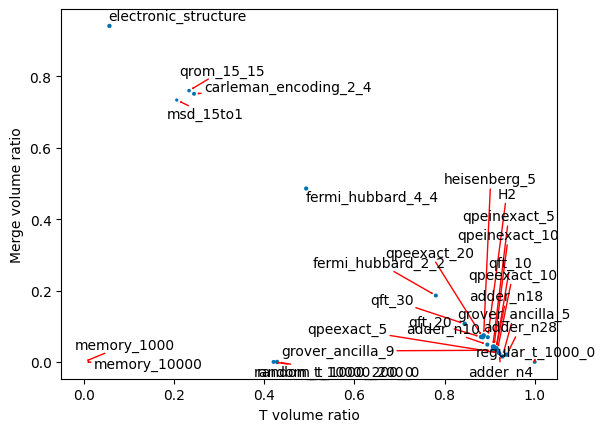

In [17]:
# scatter plot: x = t_vol_ratio, y = merge_vol_ratio, size = instruction count
# label each point with name
import adjustText
plt.figure()
plt.scatter(t_vol_ratio, merge_vol_ratio, s=np.log10(benchmark_info['Instruction count']))
texts = []
for i, txt in enumerate(benchmark_info.index):
    texts.append(plt.annotate(txt, (t_vol_ratio[i], merge_vol_ratio[i])))
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'), force_text=(0.1,0.5), max_move=None)
plt.xlabel('T volume ratio')
plt.ylabel('Merge volume ratio')